In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join('../../src'))
print(module_path)
if module_path not in sys.path:
    sys.path.append(module_path)

/home/enis/projects/nna/src


In [2]:
from fileUtils import list_files 
from pydub import AudioSegment
from IPython.display import display, Audio
from pathlib import Path
import librosa
import numpy as np
import IPython.display as ipd
import librosa.display
import matplotlib.pyplot as plt
import pandas as pd
import time

In [3]:
def load_audio(filepath,dtype=np.int16,backend="pydub"):
    if backend=="librosa":
        y, sr = librosa.load(filepath,mono=False,sr=None)
        if dtype==np.int16:
            y=y*32768
            y=y.astype(np.int16)
    elif backend=="pydub":
        y = AudioSegment.from_file(filepath)
        y = np.frombuffer(y._data,dtype=np.int16)
        y = y.reshape(-1,2).T
        if dtype==np.float32 or dtype==np.float64:
            y=y.astype(np.float32)
            y=(y/32768)
    else:
        print("no backend")
    return y


def get_clipping_percent(soundArray,threshold=1):
    if soundArray.dtype==np.int16:
        minval=int(-32768*threshold)
        maxval=int(32767*threshold)
    else:
        minval=-threshold
        maxval=threshold*0.9999 #librosa conversion from int to float causes missing precision so we lover it sligtly
    
    results=[]
    #mono
    if len(soundArray.shape)==1:
        result=(((np.sum(soundArray <= minval) + np.sum(soundArray >= maxval))) / soundArray.size)
        results.append(result)
    elif len(soundArray.shape)==2:
        results=(np.sum(soundArray<=minval,axis=1) + np.sum(soundArray>=maxval,axis=1)) / soundArray.shape[-1]
        results=list(results)
    return results
    

In [4]:
def run_task_save(allfiles,area_id,results_folder,clipping_threshold):
    all_results_dict={}
    for i,audio_file in enumerate(allfiles):
        print(audio_file)
        y=load_audio(audio_file,dtype=np.int16,backend="pydub")
        segment_len=10
        results=[]
        for clip_i in range(0,y.shape[-1]-segment_len,segment_len*sr):
            res=get_clipping_percent(y[:,clip_i:(clip_i+(segment_len*sr))],threshold=clipping_threshold)
            results.append(res)
        resultsnp=np.array(results)
        all_results_dict[audio_file]=resultsnp[:]
    clipping_threshold=str(clipping_threshold)
    clipping_threshold=clipping_threshold.replace(".",",")
    filename="{}_{}.pkl".format(area_id,clipping_threshold)
    filename=results_folder+filename
    with open(filename,'wb') as f:
        np.save(f, all_results_dict)


In [5]:
file_properties_df=pd.read_pickle("../../data/stinchcomb_dataV1.pkl")
clipping_results_path="/home/enis/projects/nna/data/clipping_results/"

In [8]:
# area_filtered=file_properties_df[file_properties_df.site_id=="11"]

In [6]:
all_areas=set(file_properties_df.site_id)

### calculate clipping values for a selected site and save as dict of numpy arrays

In [7]:
selected_areas=all_areas
clipping_threshold=1

for i,area in enumerate(selected_areas):
    area_filtered=file_properties_df[file_properties_df.site_id==area]
    run_task_save(area_filtered.index,area,clipping_results_path,clipping_threshold)
    print(area,i)


/tank/data/nna/real/stinchcomb/09-USGS/2016/USGS_20160803_005157.MP3


MemoryError: 

### performance tests

In [ ]:
bigfilepath="/tank/data/nna/real/ivvavik/SINP07/2019/SINP-07_20190827_133000.flac"

In [6]:
%%time
y16=load_audio(bigfilepath,dtype=np.int16,backend="pydub")

CPU times: user 1.4 s, sys: 2.3 s, total: 3.7 s
Wall time: 4.54 s


In [5]:
%%time
yf32=load_audio(bigfilepath,dtype=np.float32,backend="pydub")

CPU times: user 1.91 s, sys: 1min 17s, total: 1min 19s
Wall time: 1min 20s


In [8]:
%%time
ylib16=load_audio(bigfilepath,dtype=np.int16,backend="librosa")

CPU times: user 4.73 s, sys: 1min 33s, total: 1min 37s
Wall time: 1min 37s


In [7]:
%%time
ylib32=load_audio(bigfilepath,dtype=np.float32,backend="librosa")

CPU times: user 4.39 s, sys: 35.1 s, total: 39.5 s
Wall time: 39.5 s


In [129]:
# tests
# bigfile="/tank/data/nna/real/ivvavik/SINP07/2019/SINP-07_20190827_133000.flac"
# y32, sr = librosa.load(bigfile,mono=False,sr=None)
# y16 = AudioSegment.from_file(bigfile)
# y16=np.frombuffer(y16._data,dtype=np.int16)  #np.array(y16.get_array_of_samples())
# y16=y16.reshape(-1,2).T
# np.count_nonzero((y32*32768==y16))==y32.size
# np.count_nonzero((y32==(y16/32768).astype(np.float32)))==y32.size 

## experiments for deciding clipping threshold

In [16]:
# load data, 10k 10 second long samples from real dataset
results_1=[]
results_99=[]
monoresults_1=[]
monoresults_99=[]
t1=time.time()
for ii,i in enumerate(split_files):
    try:
#         y, sr = librosa.load(i,mono=False,sr=None)
        y=load_audio(i,dtype=np.int16,backend="pydub")
    except:
        print("error",i)
        pass

    # 1.0
    res=get_clipping_percent(y,1)
    if len(res)!=2:
        monoresults_1.append((i,res))
    else:
        results_1.append((i,res))
    
    #0.99
    res=get_clipping_percent(y,0.999)
    if len(res)!=2:
        monoresults_99.append((i,res))
    else:
        results_99.append((i,res))
    
    if ii%100==0:
        print(ii//100)

0
error /scratch/enis/data/nna/labeling/splits_real/S4A10288_20190601_121602_063m_52s__064m_02s.mp3
1
2
3
4
5
6
error /scratch/enis/data/nna/labeling/splits_real/S4A10283_20190524_201602_13m_57s__14m_07s.mp3
7
8
error /scratch/enis/data/nna/labeling/splits_real/S4A10252_20190505_233000_000m_22s__000m_32s.mp3
9
10
11
12
13
error /scratch/enis/data/nna/labeling/splits_real/S4A10310_20190515_054602_09m_41s__09m_51s.mp3
14
error /scratch/enis/data/nna/labeling/splits_real/S4A10245_20190514_143000_13m_27s__13m_37s.mp3
15
16
17
18
19
20
21
22
23
24
error /scratch/enis/data/nna/labeling/splits_real/S4A10290_20190529_203000_07m_39s__07m_49s.mp3
error /scratch/enis/data/nna/labeling/splits_real/S4A10287_20190505_004602_05m_06s__05m_16s.mp3
25
26
27
28
29
30
31
32
33
34
error /scratch/enis/data/nna/labeling/splits_real/S4A10270_20190508_120000_004m_29s__004m_39s.mp3
35
36
error /scratch/enis/data/nna/labeling/splits_real/S4A10245_20190531_010000_031m_08s__031m_18s.mp3
37
38
39
40
41
error /scrat

In [36]:
# sort results
results_1=sorted(results_1,key=lambda x:x[1][1])
print("worst",results_1[-1])

results_99=sorted(results_99,key=lambda x:x[1][1])
print("worst",results_99[-2])

worst ('/scratch/enis/data/nna/labeling/splits_real/S4A10287_20190508_034602_40m_54s__41m_4s.flac', [0.8022666666666667, 0.9219916666666667])


In [39]:
# create numpy array
results_1np=np.array([i[1] for i in results_1])
results_99np=np.array([i[1] for i in results_99])

In [4]:
audiofiles=list_files("/home/enis/projects/nna/notebooks/trap_photo_audio_new3")


In [478]:
for i in range(10):
    res=get_clipping_percent(y[:,(y[0].shape[0]//10)*i:(y[0].shape[0]//10)*(i+1)],0.98)
    print(i,i+1,"{:.2}   {:.2}".format(*res))

0 1 0.053   0.046
1 2 0.0   0.021
2 3 0.037   0.019
3 4 0.01   0.017
4 5 0.0   0.14
5 6 0.095   0.29
6 7 0.0   0.0
7 8 0.0   0.0
8 9 0.0088   0.061
9 10 0.0   0.12


In [18]:
# ipd.Audio(y[0], rate=sr)

In [85]:
np.sum([results_1np[:,1]<=0])

2623

In [92]:
results_1np[2622]

array([0.01837292, 0.        ])

[0.0021770833333333334, 0.0011770833333333334]


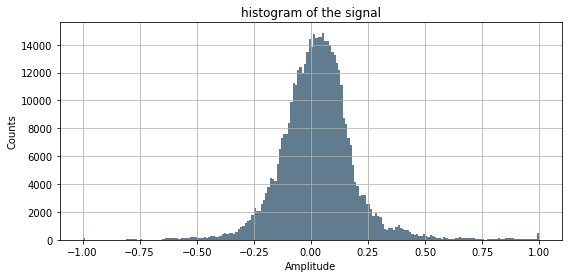

In [110]:
# y, sr = librosa.load(Path(audiofiles[15]),mono=False,sr=None)
# ymono, sr = librosa.load(Path(audiofiles[15]),mono=True,sr=None)
sample=results_99[2800]
print(sample[1])
worst_path=sample[0]

y, sr = librosa.load(Path(worst_path),mono=False,sr=None)
ymono, sr = librosa.load(Path(worst_path),mono=True,sr=None)


# Generate data on commute times.
commutes = pd.Series(y[1])
# commutes = pd.Series(clipped)

commutes.plot.hist(cumulative=False,grid=True, bins=200, rwidth=0.999,
                   color='#617c8e',figsize=(9,4))
# commutes.plot()
plt.title('histogram of the signal')
plt.ylabel('Counts')
plt.xlabel('Amplitude')
plt.grid(axis='y', alpha=0.9)
# plt.savefig("cum_hist_1000bins.png",bbox_inches='tight',pad_inches=0.0)

In [496]:
# ipd.Audio(ymono, rate=sr)

In [497]:
# ipd.Audio(y[0], rate=sr)

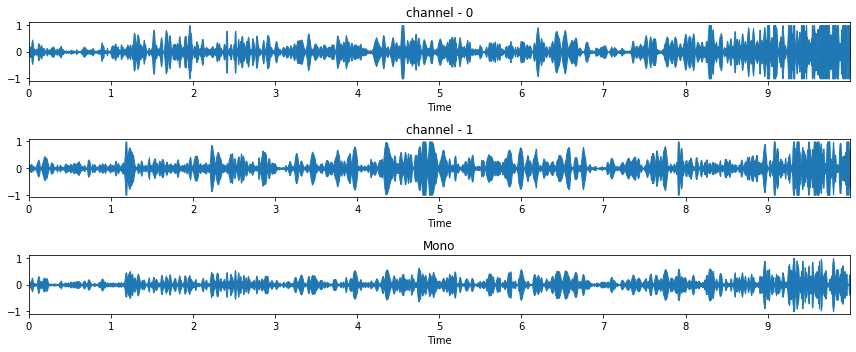

In [106]:
# Plot a monophonic waveform
# y, sr = librosa.load(librosa.util.example_audio_file(), duration=10)
plt.figure(figsize=(12, 5))

plt.subplot(3, 1, 1)
librosa.display.waveplot(np.asfortranarray(y[0]), sr=sr)
plt.title('channel - 0')

# plt.figure(figsize=(12, 3))

plt.subplot(3, 1, 2)
librosa.display.waveplot(np.asfortranarray(y[1]), sr=sr)
plt.title('channel - 1')

plt.subplot(3, 1, 3)
librosa.display.waveplot(np.asfortranarray(ymono), sr=sr)
plt.title('Mono')
# plt.savefig('books_read.png')
# plt.show()
plt.tight_layout()
# plt.savefig('multiple.png')


In [507]:
ipd.Audio(y[0], rate=sr)

In [504]:
ipd.Audio(y[1], rate=sr)

In [ ]:
"mono: {:.2}  cha1: {:.2}  cha2: {:.2}".format(*get_clipping_percent(y,1))


In [ ]:
soundArray=np.array(y)

In [ ]:
ynp.shape

In [ ]:
np.sum(soundArray[0] >= 0.99) / np.sum(soundArray[0] > 0)

In [ ]:
(np.sum(soundArray[0] <= -0.99))  /  np.sum(soundArray[0] < 0)

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
len(np.where( ynp[0] > 0.9)[0])/2880000

In [ ]:
# results=[]
# for i in audiofiles:
#     y, sr = librosa.load(i,mono=False,sr=None)
#     soundArray=np.array(y)
#     result=(((np.sum(soundArray[1] <= -0.99) + np.sum(soundArray[1] >= 0.99))) / soundArray[1].size)
#     results.append(result)

In [ ]:
for audiof in audiofiles:
    y, sr = librosa.load(audiof,mono=False,sr=None)
    print("mono: {:.2}  cha1: {:.2}  cha2: {:.2}".format(*get_clipping_percent(y,1)))


In [12]:
split_files=list_files("/scratch/enis/data/nna/labeling/splits_real")

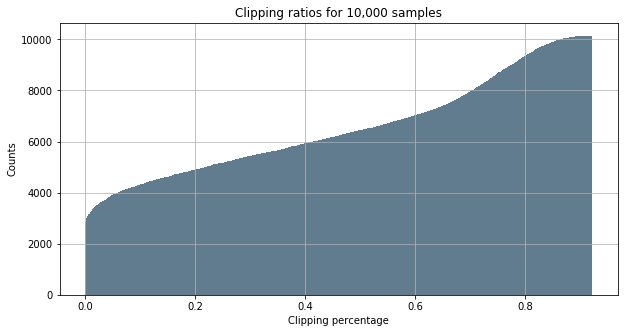

In [42]:

results_series=results_99np[:,1]
# results_series=results_series[results_series<=0.025]

# Generate data on commute times.
commutes = pd.Series(results_series)

commutes.plot.hist(cumulative=True,grid=True, bins=1000, rwidth=0.999,
                   color='#617c8e',figsize=(10,5))
plt.title('Clipping ratios for 10,000 samples')
plt.ylabel('Counts')
plt.xlabel('Clipping percentage')
plt.grid(axis='y', alpha=0.9)
plt.savefig("cum_hist_1000bins.png",bbox_inches='tight',pad_inches=0.0)

In [53]:
threshold=1
thresholdlowwer=0.2
results_1np[(results_1np[:,0]<=threshold) & (results_1np[:,1]<=threshold)].shape
upper=results_1np[(results_1np[:,0]<=threshold) & (results_1np[:,1]<=threshold)]
upper[(thresholdlowwer<upper[:,0]) & (thresholdlowwer<upper[:,1])].shape


(4752, 2)

In [52]:
threshold=0.2
thresholdlowwer=0.08
results_1np[(results_1np[:,0]<=threshold) & (results_1np[:,1]<=threshold)].shape
upper=results_1np[(results_1np[:,0]<=threshold) & (results_1np[:,1]<=threshold)]
upper[(thresholdlowwer<upper[:,0]) & (thresholdlowwer<upper[:,1])].shape


(201, 2)

In [49]:
threshold=0.08
thresholdlowwer=0.02
upper=results_1np[(results_1np[:,0]<=threshold) & (results_1np[:,1]<=threshold)]
upper[(thresholdlowwer<upper[:,0]) & (thresholdlowwer<upper[:,1])].shape


(173, 2)

In [50]:
threshold=0.02
thresholdlowwer=0.001

upper=results_1np[(results_1np[:,0]<=threshold) & (results_1np[:,1]<=threshold)]
upper[(thresholdlowwer<upper[:,0]) & (thresholdlowwer<upper[:,1])].shape


(215, 2)

In [561]:
# 

In [51]:
threshold=0.001
# thresholdlowwer=0
upper=results_1np[(results_1np[:,0]<=threshold) & (results_1np[:,1]<=threshold)]
print(upper.shape)
# upper[(thresholdlowwer>upper[:,0]) & (thresholdlowwer>upper[:,1])].shape


(2413, 2)


In [54]:
2413+4752

7165